In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import random
from tqdm.auto import tqdm
import imageio
import einops
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torchvision.datasets import FashionMNIST
import os
device = torch.device("cuda:0")

In [2]:
import importlib
from GAN_modules import * 
from DDGAN import *

In [3]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
batch_size = 64

dataset = FashionMNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [4]:
def training_loop(ddgan, loader, n_epochs, optimizerG, optimizerD, device, r1,
                  schedulerG=None, schedulerD=None, store_path="ddgan_model.pt"):

    best_loss = float("inf")
    n_steps = ddgan.n_steps
    netG = ddgan.generator
    netD = ddgan.discriminator

    pos_coeff = Posterior_Coefficients(ddgan, device)

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        print(f'Epoch {epoch+1}/{n_epochs}')
        
        epoch_errG = 0.0
        epoch_errD = 0.0
           
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            for p in netD.parameters():
                p.requires_grad = True
                
            netD.zero_grad()
                
            x0 = batch[0].to(device)
            n = len(x0)
            
            t = torch.randint(0, n_steps, (n,)).to(device)
              
            x_t, x_tp1 = q_sample_pairs(ddgan, x0, t)
            x_t.requires_grad = True
            
            #train D with real            
            D_real = netD(x_t, t, x_tp1.detach()).view(-1)
            errD_real = (torch.exp(D_real)).mean()
            
            errD_real.backward(retain_graph=True)
                
            grad_real = torch.autograd.grad(
                    outputs=D_real.sum(), inputs=x_t, create_graph=True)[0]
            grad_penalty = (
                grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2
                            ).mean()  
            grad_penalty = r1 / 2 * grad_penalty
            grad_penalty.backward()
                                           
            #train D with fake from G
            latent_z = torch.randn(n, netG.zsize).to(device)
            
            x_0_predict = netG(x_tp1, t, latent_z)
            x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)
            
            output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
    
            errD_fake = (-output).mean()
            errD_fake.backward()
            
            errD = errD_real.detach() + errD_fake.detach()
            optimizerD.step()    
            
            #train G without D
            for p in netD.parameters():
                p.requires_grad = False
            netG.zero_grad()
            
            
            t = torch.randint(0, n_steps, (n,)).to(device)
            
            x_t, x_tp1 = q_sample_pairs(ddgan, x0, t)
            
            latent_z = torch.randn(n, netG.zsize).to(device)
            
            x_0_predict = netG(x_tp1.detach(), t, latent_z)
            x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)
            
            output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)     
            
            errG = (output).mean()
            
            errG.backward()
            optimizerG.step()

            epoch_errG += errG.detach() * n / len(loader.dataset)
            epoch_errD += errD.detach() * n / len(loader.dataset)
        
        if schedulerD is not None:
            schedulerD.step()
        if schedulerG is not None:
            schedulerG.step()

        log_string = f"G loss: {epoch_errG:.4f}, D loss: {epoch_errD:.4f}"

        # Storing the model
        torch.save(ddgan.state_dict(), store_path)
        print(log_string)
        print('-' * 75)
    torch.cuda.empty_cache()

In [5]:
from CustomizableCosineDecayScheduler import CosineDecayWithWarmUpScheduler as CD_scheduler
n_steps, min_beta, max_beta = 10, 3e-1, 9e-1
r1 = 0.000001

In [8]:
try:
    del generator
except: pass
try:
    del discriminator
except: pass
try:
    del ddgan
except: pass
torch.cuda.empty_cache()


generator = Generator(time_emb_dim=50, n_steps=n_steps, device=device, zsize=100)
discriminator = Discriminator(time_emb_dim=50, n_steps=n_steps, device=device)


ddgan = DDGAN(generator, discriminator, n_steps=n_steps, 
              min_beta=min_beta, max_beta=max_beta, emb_dim=50,
              device=device).to(device)
#ddgan = best_model

optimizerG = optim.Adam(ddgan.generator.parameters(), betas=(0.7, 0.99),
                       lr=3e-5)
optimizerD = optim.Adam(ddgan.discriminator.parameters(), betas=(0.7, 0.99),
                       lr=3e-5)

schedulerG = CD_scheduler(optimizerG, 
                    max_lr=3e-4, min_lr=2e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.5, alpha=0.3)
schedulerD = CD_scheduler(optimizerG, 
                    max_lr=3e-4, min_lr=2e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.4, alpha=0.2)

ddgan.train()
training_loop(ddgan, loader, n_epochs=60, optimizerG=optimizerG, optimizerD=optimizerD, 
              r1=r1, schedulerG=schedulerG, schedulerD=schedulerD,
              device=device, store_path="ddgan_rkl_model.pt")

Training progress:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60


Epoch 1/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0445, D loss: 0.9426
---------------------------------------------------------------------------
Epoch 2/60


Epoch 2/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.0006, D loss: 1.0005
---------------------------------------------------------------------------
Epoch 3/60


Epoch 3/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0061, D loss: 0.9971
---------------------------------------------------------------------------
Epoch 4/60


Epoch 4/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0285, D loss: 0.9862
---------------------------------------------------------------------------
Epoch 5/60


Epoch 5/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.0032, D loss: 1.0010
---------------------------------------------------------------------------
Epoch 6/60


Epoch 6/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0050, D loss: 0.9974
---------------------------------------------------------------------------
Epoch 7/60


Epoch 7/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0009, D loss: 0.9997
---------------------------------------------------------------------------
Epoch 8/60


Epoch 8/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0022, D loss: 0.9971
---------------------------------------------------------------------------
Epoch 9/60


Epoch 9/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0027, D loss: 0.9997
---------------------------------------------------------------------------
Epoch 10/60


Epoch 10/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0005, D loss: 0.9998
---------------------------------------------------------------------------
Epoch 11/60


Epoch 11/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0112, D loss: 0.9954
---------------------------------------------------------------------------
Epoch 12/60


Epoch 12/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0406, D loss: 0.9706
---------------------------------------------------------------------------
Epoch 13/60


Epoch 13/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0431, D loss: 0.9631
---------------------------------------------------------------------------
Epoch 14/60


Epoch 14/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0526, D loss: 0.9558
---------------------------------------------------------------------------
Epoch 15/60


Epoch 15/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0594, D loss: 0.9479
---------------------------------------------------------------------------
Epoch 16/60


Epoch 16/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0717, D loss: 0.9333
---------------------------------------------------------------------------
Epoch 17/60


Epoch 17/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0905, D loss: 0.9103
---------------------------------------------------------------------------
Epoch 18/60


Epoch 18/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.1049, D loss: 0.9006
---------------------------------------------------------------------------
Epoch 19/60


Epoch 19/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.1270, D loss: 0.8772
---------------------------------------------------------------------------
Epoch 20/60


Epoch 20/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.1286, D loss: 0.8667
---------------------------------------------------------------------------
Epoch 21/60


Epoch 21/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.1369, D loss: 0.8603
---------------------------------------------------------------------------
Epoch 22/60


Epoch 22/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.0015, D loss: 1.0041
---------------------------------------------------------------------------
Epoch 23/60


Epoch 23/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.0124, D loss: 1.0138
---------------------------------------------------------------------------
Epoch 24/60


Epoch 24/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0195, D loss: 0.9864
---------------------------------------------------------------------------
Epoch 25/60


Epoch 25/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0720, D loss: 0.9386
---------------------------------------------------------------------------
Epoch 26/60


Epoch 26/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0515, D loss: 0.9538
---------------------------------------------------------------------------
Epoch 27/60


Epoch 27/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0482, D loss: 0.9593
---------------------------------------------------------------------------
Epoch 28/60


Epoch 28/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0353, D loss: 0.9683
---------------------------------------------------------------------------
Epoch 29/60


Epoch 29/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0439, D loss: 0.9607
---------------------------------------------------------------------------
Epoch 30/60


Epoch 30/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0464, D loss: 0.9597
---------------------------------------------------------------------------
Epoch 31/60


Epoch 31/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0401, D loss: 0.9626
---------------------------------------------------------------------------
Epoch 32/60


Epoch 32/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0533, D loss: 0.9517
---------------------------------------------------------------------------
Epoch 33/60


Epoch 33/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0470, D loss: 0.9548
---------------------------------------------------------------------------
Epoch 34/60


Epoch 34/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0589, D loss: 0.9443
---------------------------------------------------------------------------
Epoch 35/60


Epoch 35/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0725, D loss: 0.9330
---------------------------------------------------------------------------
Epoch 36/60


Epoch 36/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0854, D loss: 0.9156
---------------------------------------------------------------------------
Epoch 37/60


Epoch 37/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0760, D loss: 0.9288
---------------------------------------------------------------------------
Epoch 38/60


Epoch 38/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0758, D loss: 0.9345
---------------------------------------------------------------------------
Epoch 39/60


Epoch 39/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.1230, D loss: 0.8773
---------------------------------------------------------------------------
Epoch 40/60


Epoch 40/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.1361, D loss: 0.8646
---------------------------------------------------------------------------
Epoch 41/60


Epoch 41/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.1270, D loss: 0.8738
---------------------------------------------------------------------------
Epoch 42/60


Epoch 42/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0821, D loss: 0.9294
---------------------------------------------------------------------------
Epoch 43/60


Epoch 43/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0833, D loss: 0.9325
---------------------------------------------------------------------------
Epoch 44/60


Epoch 44/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0652, D loss: 0.9395
---------------------------------------------------------------------------
Epoch 45/60


Epoch 45/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0667, D loss: 0.9381
---------------------------------------------------------------------------
Epoch 46/60


Epoch 46/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0689, D loss: 0.9344
---------------------------------------------------------------------------
Epoch 47/60


Epoch 47/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0614, D loss: 0.9408
---------------------------------------------------------------------------
Epoch 48/60


Epoch 48/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0494, D loss: 0.9594
---------------------------------------------------------------------------
Epoch 49/60


Epoch 49/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0574, D loss: 0.9428
---------------------------------------------------------------------------
Epoch 50/60


Epoch 50/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0709, D loss: 0.9330
---------------------------------------------------------------------------
Epoch 51/60


Epoch 51/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0642, D loss: 0.9388
---------------------------------------------------------------------------
Epoch 52/60


Epoch 52/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0191, D loss: 1.0259
---------------------------------------------------------------------------
Epoch 53/60


Epoch 53/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0518, D loss: 0.9576
---------------------------------------------------------------------------
Epoch 54/60


Epoch 54/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0643, D loss: 0.9375
---------------------------------------------------------------------------
Epoch 55/60


Epoch 55/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0420, D loss: 1.0077
---------------------------------------------------------------------------
Epoch 56/60


Epoch 56/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0675, D loss: 0.9308
---------------------------------------------------------------------------
Epoch 57/60


Epoch 57/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0526, D loss: 0.9541
---------------------------------------------------------------------------
Epoch 58/60


Epoch 58/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0878, D loss: 0.9290
---------------------------------------------------------------------------
Epoch 59/60


Epoch 59/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0086, D loss: 1.5234
---------------------------------------------------------------------------
Epoch 60/60


Epoch 60/60:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0730, D loss: 0.9356
---------------------------------------------------------------------------


In [6]:
store_path="ddgan_rkl_model.pt"

generator = Generator(time_emb_dim=50, n_steps=n_steps, device=device)
discriminator = Discriminator(time_emb_dim=50, n_steps=n_steps, device=device)

best_model = DDGAN(generator, discriminator, n_steps=n_steps, 
                   device=device, emb_dim=50)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print()

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

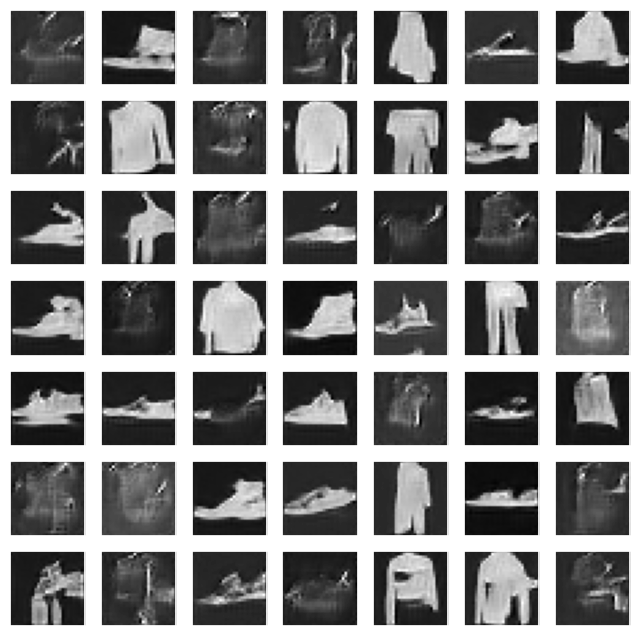

In [14]:
best_model.eval()
generated = generate_new_images(
        best_model,
        n_samples=49,
        n_steps=10
    )
show_images(generated, save_path=None)

In [7]:
# fake samples
n_samples=50000

os.makedirs(f"generated_ddgan_rkl_FMNIST", exist_ok=True)

num_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for n in tqdm(num_steps, desc=f"Generating progress", colour="#00dd00"):
    
    torch.cuda.empty_cache()
    
    with torch.no_grad():

        generated = generate_new_images(
            best_model,
            n_samples=n_samples,
            n_steps=n
        )

    os.makedirs(f"generated_ddgan_rkl_FMNIST/{n}", exist_ok=True)
    
    for i in range(len(generated)):
        img = generated[i]
        img -= img.min()
        img /= img.max()
        img = torch.cat([img,img,img])
        save_image(img, f"generated_ddgan_rkl_FMNIST/{n}/img{i}.png")

Generating progress:   0%|          | 0/10 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
# extract features and calculate FID
from FID import extract_real_features, FID_score

# path_real = "datasets/FashionMNIST_png/"
# real_features = extract_real_features(path_real)

# with open('real_features.npy', "wb") as f:
#     np.save(f, real_features)
# torch.cuda.empty_cache()

with open("real_features.npy", 'rb') as f:
    real_features = np.load(f)

In [9]:
path_real = "real_features.npy"
num_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

scores = []

for n in tqdm(num_steps, leave=False, desc=f"Progress", colour="#009900"):
    torch.cuda.empty_cache()
    path_fake = f"generated_ddgan_rkl_FMNIST/{n}/"
    scores.append(FID_score(path_real, path_fake, True))

with open('FID_scores_FMNIST_ddgan_rkl.npy', "wb") as f:
    np.save(f, np.array(scores))

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
with open('FID_scores_FMNIST_ddgan_rkl.npy', "rb") as f:
    scores = np.load(f)

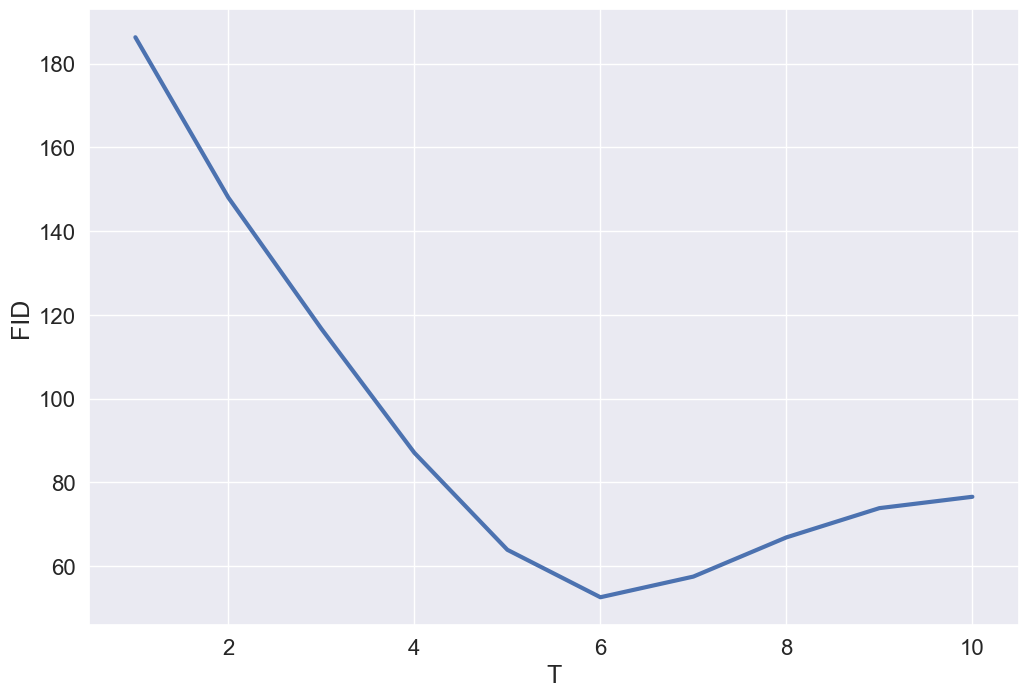

In [11]:
import seaborn as sns
sns.set_theme(style='darkgrid')

plt.figure(figsize=(12,8))

plt.plot(num_steps, scores, lw=3)

plt.xlabel("T", fontsize=18)
plt.ylabel("FID", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(left=0.5, right=10.5)

plt.savefig("DDGAN_RKL_FID_FMNIST.png", bbox_inches='tight')
plt.show()